# 1.1 Data

In [136]:
# Imports
import numpy as np
from glob import glob
from os import path
from scipy.special import comb
from scipy.optimize import minimize
from scipy.stats import binom
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

data_dir = "data"
file_paths = glob(path.join(data_dir, "*.txt"))

# N x M x K
# 5 FILES x 7 ROWS  x 5 COLUMNS
# ROW 1: Audio 
# ROW 2: Visual
# ROW 3-7: Visual going from 'b' (row 3) to 'd' (row 7)
# Columns: Audio from 'b' (col 1) to 'd' (col 5)
data = np.array([np.loadtxt(fname) for fname in file_paths], dtype=np.int64)
N, M, K = data.shape

AUDIO_DATA       = data[:, 0, :]
VISUAL_DATA      = data[:, 1, :]
AUDIOVISUAL_DATA = data[:, 2:, :]

In [137]:
def baseline_softmax(theta):
    e = np.exp(theta)
    return e / (e +1 )

In [138]:
def binomial_pmf(k, n, p):
    return comb(n, k) * np.power(p, k) * np.power(1 - p, n - k)

In [139]:
args = (data[0], 24, np.vstack([p_a.T, p_v.T, p_av]))
np.isclose(binom.logpmf(*args), np.log(binomial_pmf(*args)))

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [140]:
def objective_function(theta, subject_data):
    theta_a = theta[0:K]
    theta_v = theta[K: ]

    p_a = np.array([baseline_softmax(theta) for theta in theta_a]).reshape(-1,1)
    p_v = np.array([baseline_softmax(theta) for theta in theta_v]).reshape(-1,1)
    
    # Outer product for all combinations
    p_av = (p_a @ p_v.T) / (p_a @ p_v.T + (1 - p_a) @ (1 - p_v).T)
    # likelihoods = binom.logpmf(subject_data, 24, np.vstack([p_a.T, p_v.T, p_av]))
    likelihoods = np.log(binomial_pmf(subject_data, 24, np.vstack([p_a.T, p_v.T, p_av])))

    return -(likelihoods.sum())
p_set = []
for i in range(5):
    
    theta = np.random.randn(K*2)
    opt_result = minimize(objective_function, theta, args=(data[i]))
    objective, theta_a, theta_v, success = (
        opt_result.fun, 
        (opt_result.x[0:K]), 
        (opt_result.x[K:]), 
        opt_result.success
    )

    print("Subject ", i)
    print("Converged:",success, "NLL:",objective)
    print("theta_a", theta_a)
    print("theta_v", theta_v)
    p_a = np.array([baseline_softmax(theta) for theta in theta_a]).reshape(-1,1)
    p_v = np.array([baseline_softmax(theta) for theta in theta_v]).reshape(-1,1)
    p_av = (p_a @ p_v.T) / (p_a @ p_v.T + (1 - p_a) @ (1 - p_v).T)
    p_set.append(np.vstack([p_a.T, p_v.T, p_av]))
    print("===")
    print("p_a", p_a.flatten())
    print("p_v", p_v.flatten())
    print("p_av\n", np.round(p_av, 3))
    print("===")
    print("data")
    print(np.round(binom.pmf(data[i][2:], 24, p_av), 3))
    print("\n\n")

Subject  0
Converged: True NLL: 70.2576578605069
theta_a [-4.78771531 -1.95605375 -0.25823498  1.43526752  1.67202769]
theta_v [-1.11834348  0.51165139  1.54670829  4.28161073  5.03519724]
===
p_a [0.00826263 0.12389476 0.43579764 0.80772073 0.84184598]
p_v [0.24631868 0.62519352 0.8244378  0.98636802 0.99353713]
p_av
 [[0.003 0.014 0.038 0.376 0.562]
 [0.044 0.191 0.399 0.911 0.956]
 [0.202 0.563 0.784 0.982 0.992]
 [0.579 0.875 0.952 0.997 0.998]
 [0.635 0.899 0.962 0.997 0.999]]
===
data
[[0.937 0.718 0.398 0.15  0.16 ]
 [0.016 0.044 0.097 0.103 0.198]
 [0.025 0.138 0.196 0.653 0.818]
 [0.163 0.017 0.216 0.924 0.964]
 [0.143 0.059 0.375 0.94  0.971]]



Subject  1
Converged: True NLL: 41.79765647023841
theta_a [-6.55473366 -1.91458376  0.3448921   3.09946747  3.8780474 ]
theta_v [-1.63230411  1.07303181  2.55000219  4.14860462  6.12230354]
===
p_a [0.00142134 0.12846677 0.58537838 0.95687077 0.97972826]
p_v [0.16351497 0.74517305 0.92757366 0.98445891 0.9978114 ]
p_av
 [[0.    0.004

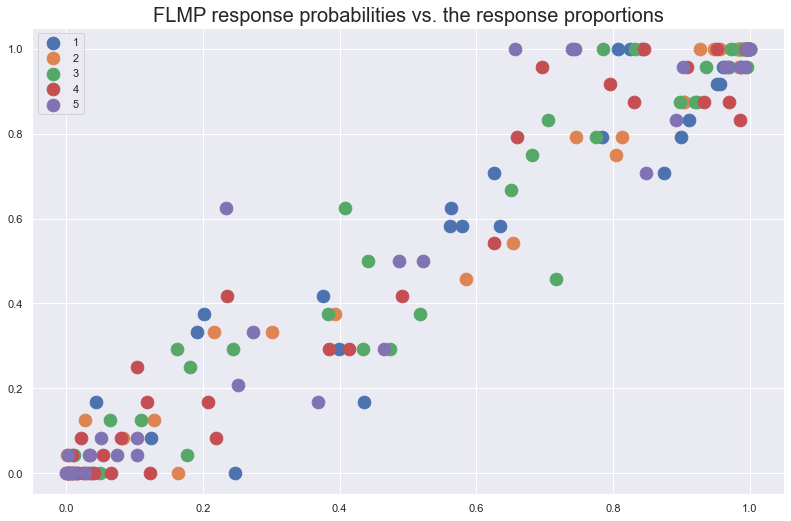

In [141]:

x = p_set
y = list(data/24)

fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(111)


for idx, color in enumerate(colors):
    ax1.scatter(x[idx], y[idx],s=160,label=idx+1)
plt.legend(loc='upper left')
plt.title("FLMP response probabilities vs. the response proportions",fontsize=20)
plt.style.use('fivethirtyeight')
plt.show()
